In [1]:
from model import CNN
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

CHANNELS_D = 3

img_size = 400
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "model.pth"
data_dir = "~/Documents/datasets/archive/caltech101_classification/"

classes = ["Motorcycle", "Airplane", "Schooner"]

In [2]:
def norm_transforms(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unorm

norm, unorm = norm_transforms(data_dir)

In [3]:
def load_data(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(
        root=dir,
        transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])
    
train_data, test_data = load_data("~/Documents/datasets/archive/caltech101_classification/")

In [4]:
def gen_layers(num_layers, expansion):
    layers = []
    in_channels = 3
    
    for i in range(num_layers):
        out_channels = expansion * in_channels
        layers += [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(2, 2)]
        in_channels = out_channels

    # num params
    # print(((img_size // (2 ** num_layers)) ** 2) * in_channels)
    fcl = ((img_size // (2 ** num_layers)) ** 2) * in_channels
    layers += [nn.Flatten(1), nn.Linear(fcl, 256), nn.ReLU()]
    layers += [nn.Linear(256, 3), nn.ReLU()]
    
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.expansion = expansion
        self.num_layers = num_layers
        self.net = nn.Sequential(
            gen_layers(self.num_layers, self.expansion)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def train(model, train_data, batch, epochs, lr):
    CHANNELS_D = 3
    # LEARNING_RATE = 1e-4

    loader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(loader):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'epoch: {epoch + 1} loss: {running_loss / batch:.3f}')
        running_loss = 0.0
    
    return model

def save(model, path):
    torch.save(model.state_dict(), path)

In [6]:
model = CNN(2, 2).to(device)
model = train(model, train_data, batch=50, epochs=100, lr=1e-4)
# 95.495% correct

epoch: 1 loss: 0.589
epoch: 2 loss: 0.568
epoch: 3 loss: 0.547
epoch: 4 loss: 0.526
epoch: 5 loss: 0.505
epoch: 6 loss: 0.484
epoch: 7 loss: 0.463
epoch: 8 loss: 0.442
epoch: 9 loss: 0.420
epoch: 10 loss: 0.400
epoch: 11 loss: 0.380
epoch: 12 loss: 0.359
epoch: 13 loss: 0.342
epoch: 14 loss: 0.326
epoch: 15 loss: 0.313
epoch: 16 loss: 0.299
epoch: 17 loss: 0.288
epoch: 18 loss: 0.279
epoch: 19 loss: 0.269
epoch: 20 loss: 0.263
epoch: 21 loss: 0.254
epoch: 22 loss: 0.250
epoch: 23 loss: 0.243
epoch: 24 loss: 0.240
epoch: 25 loss: 0.236
epoch: 26 loss: 0.231
epoch: 27 loss: 0.224
epoch: 28 loss: 0.222
epoch: 29 loss: 0.218
epoch: 30 loss: 0.212
epoch: 31 loss: 0.211
epoch: 32 loss: 0.206
epoch: 33 loss: 0.201
epoch: 34 loss: 0.198
epoch: 35 loss: 0.194
epoch: 36 loss: 0.190
epoch: 37 loss: 0.186
epoch: 38 loss: 0.185
epoch: 39 loss: 0.180
epoch: 40 loss: 0.177
epoch: 41 loss: 0.174
epoch: 42 loss: 0.169
epoch: 43 loss: 0.165
epoch: 44 loss: 0.162
epoch: 45 loss: 0.159
epoch: 46 loss: 0.1

(1) Prediction: Airplane, Actual: Airplane
(2) Prediction: Airplane, Actual: Airplane
(3) Prediction: Motorcycle, Actual: Motorcycle
(4) Prediction: Motorcycle, Actual: Motorcycle
(5) Prediction: Motorcycle, Actual: Motorcycle
(6) Prediction: Airplane, Actual: Airplane
(7) Prediction: Motorcycle, Actual: Motorcycle
(8) Prediction: Motorcycle, Actual: Motorcycle
(9) Prediction: Airplane, Actual: Airplane
(10) Prediction: Airplane, Actual: Airplane
(11) Prediction: Motorcycle, Actual: Motorcycle
(12) Prediction: Motorcycle, Actual: Motorcycle
(13) Prediction: Airplane, Actual: Airplane
(14) Prediction: Motorcycle, Actual: Motorcycle
(15) Prediction: Motorcycle, Actual: Motorcycle
(16) Prediction: Motorcycle, Actual: Motorcycle

 16 / 16 correct -> 100.0 %


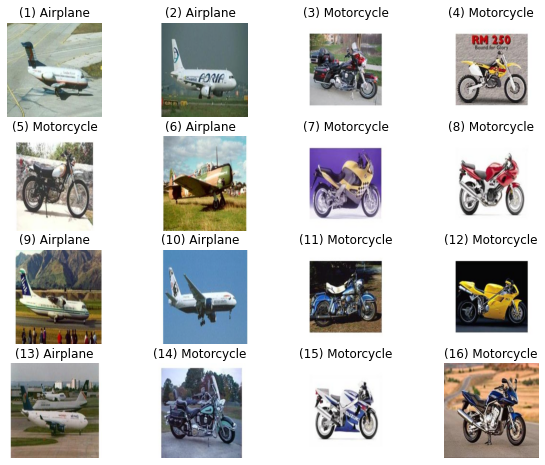

In [20]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> {correct / (cols * rows) * 100} %")
        plt.show()
        
sample(model, test_data)

In [27]:
def eval(data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)

            pred = model(img_input).to('cpu')
            _, pred = torch.max(pred.squeeze(), 0)
            
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n{(correct / len(data) * 100):.3f}% correct")

model.eval()
eval(test_data)
model.train()


95.495% correct
